In [1]:
import pandas as pd
import numpy as np

In [5]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

## Logistic Regression

In [161]:
# preprocessing : 股價的漲 (1) or 跌 (0) label
def add_label(df, column):
    label = []
    for i in range(len(df)):
        if(i == 0):
            label.append(0)
            continue
        if(df[column][i] >= df[column][i - 1]):
            label.append(1)
        else:
            label.append(0)
    return pd.Series(label)
    
train_length = len(train)
train["label"] = add_label(train, "Close Price")
test["label"] = add_label(test, "Close Price")
train.head()

,Open Price,Close Price,High Price,Low Price,Volume,label
0,0.111109,0.126771,0.119748,0.115178,4048270080,0
1,0.124112,0.124611,0.120698,0.125173,5413910016,0
2,0.125105,0.128211,0.124309,0.129011,5392620032,1
3,0.123257,0.114281,0.116107,0.116674,4704940032,0
4,0.112470,0.115811,0.107381,0.113920,4991549952,1


In [162]:
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# 取出參考的 columns
x_list = ["Open Price", "Close Price", "High Price", "Low Price"]
train_x = train[x_list]
train_y = train["label"]

test_x = test[x_list]
test_y = test["label"]

print("Train size: %d, Test size: %d" % (len(train), len(test)))

# train model & predict
model = LogisticRegression()
model.fit(train_x, train_y)

pred_y = model.predict(test_x)
print("accuracy :", end=" ")
print(str(round(metrics.accuracy_score(pred_y, test_y) * 100, 2)) + " %" )

Train size: 2264, Test size: 252
accuracy : 48.41 %


## Neural Network - 1

<br/>
reference :
- [股票LSTM分析(2)-Classifiacion](https://mc.ai/%E8%82%A1%E7%A5%A8lstm%E5%88%86%E6%9E%902-classifiacion/)
- [Keras](https://keras.io/zh/getting-started/sequential-model-guide/)

In [147]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

train = train.drop(["Date"], axis=1)
test = test.drop(["Date"], axis=1)

train["label"] = add_label(train, "Close Price")
test["label"] = add_label(test, "Close Price")

In [148]:
from sklearn import preprocessing

x_list = ["Open Price", "Close Price", "High Price", "Low Price"]

# 正規化
scaler = MinMaxScaler()
train[x_list] = scaler.fit_transform(train[x_list])
train.head()

,Open Price,Close Price,High Price,Low Price,Volume,label
0,0.111109,0.126771,0.119748,0.115178,4048270080,0
1,0.124112,0.124611,0.120698,0.125173,5413910016,0
2,0.125105,0.128211,0.124309,0.129011,5392620032,1
3,0.123257,0.114281,0.116107,0.116674,4704940032,0
4,0.112470,0.115811,0.107381,0.113920,4991549952,1


In [149]:
# 以 5 天為單位當作一個輸入資料
def extract_days(df, ref_day = 5, predict_day = 1):
    X_train, Y_train = [], []
    tmp = df[["Open Price", "Close Price", "High Price", "Low Price"]]
    for i in range(df.shape[0] - predict_day - ref_day):
        X_train.append(np.array(tmp.iloc[i: i + ref_day,: ]))
        Y_train.append(np.array(df["label"][i + ref_day: i + ref_day + predict_day,]))
    return np.array(X_train), np.array(Y_train)

train_x, train_y = extract_days(train, 5, 1)
test_x, test_y = extract_days(test, 5, 1)

print("finish")

finish


In [150]:
print("train_x set shape: ", str(train_x.shape))
print("train label 0 v.s. 1 :", end=" ")
print(list(train_y).count(0), list(train_y).count(1))

print("- - -")

print("test_x set shape: ", str(test_x.shape))
print("test  label 0 v.s. 1 :", end=" ")
print(list(test_y).count(0), list(test_y).count(1))

train_x set shape:  (2258, 5, 4)
train label 0 v.s. 1 : 1021 1237
- - -
test_x set shape:  (246, 5, 4)
test  label 0 v.s. 1 : 119 127


In [151]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

regressor = Sequential()

regressor.add(LSTM(units = 30, return_sequences = True, input_shape = (train_x.shape[1], train_x.shape[2])))
regressor.add(Dropout(0.5))

regressor.add(LSTM(units = 30, return_sequences = True))
regressor.add(Dropout(0.5))

regressor.add(LSTM(units = 30))
regressor.add(Dropout(0.5))

regressor.add(Dense(units = 1, activation='sigmoid'))
# regressor.add(Dense(units = 1, activation='relu'))
regressor.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

regressor.fit(train_x, train_y, epochs = 10, batch_size = 64)

print("finish")

Epoch 1/10
2258/2258 [==============================] - 2s 900us/step - loss: 0.6903 - accuracy: 0.5394
Epoch 2/10
2258/2258 [==============================] - 1s 224us/step - loss: 0.6899 - accuracy: 0.5478
Epoch 3/10
2258/2258 [==============================] - 1s 224us/step - loss: 0.6896 - accuracy: 0.5478
Epoch 4/10
2258/2258 [==============================] - 1s 255us/step - loss: 0.6894 - accuracy: 0.5478
Epoch 5/10
2258/2258 [==============================] - 0s 220us/step - loss: 0.6887 - accuracy: 0.5478
Epoch 6/10
2258/2258 [==============================] - 1s 235us/step - loss: 0.6890 - accuracy: 0.5469
Epoch 7/10
2258/2258 [==============================] - 1s 235us/step - loss: 0.6888 - accuracy: 0.5474
Epoch 8/10
2258/2258 [==============================] - 1s 241us/step - loss: 0.6900 - accuracy: 0.5456
Epoch 9/10
2258/2258 [==============================] - 1s 232us/step - loss: 0.6887 - accuracy: 0.5478
Epoch 10/10
2258/2258 [==============================] - 1s 235u

In [152]:
predict_y = regressor.predict(test_x)
predict_y = pd.DataFrame(predict_y).values.astype(float)
print("finish")

finish


In [153]:
def convert_to_label(predict):
    data = []
    for i in range(len(predict)):
        if(predict_y[i] > 0.5):
            data.append(1)
        else:
            data.append(0)
    return data
pred_yy = np.array(updown(predict_y))
pred_yy

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1])

In [154]:
print("accuracy :", end=" ")
print(str(round(metrics.accuracy_score(pred_yy, test_y) * 100, 2)) + " %" )

accuracy : 51.63 %


### Nuural Network 2
<br/>
reference : [實作透過lstm預測股票](https://wenwender.wordpress.com/2019/10/18/%E5%AF%A6%E4%BD%9C%E9%80%8F%E9%81%8Elstm%E9%A0%90%E6%B8%AC%E8%82%A1%E7%A5%A8/)

In [128]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [129]:
len(test)

252

In [117]:
from sklearn.preprocessing import MinMaxScaler 

train_set = train[['Close Price']]
test_set = test[['Close Price']]

# preprocessing: 資料正規化
sc = MinMaxScaler(feature_range = (0, 1))
train_set= train_set.values.reshape(-1, 1)
training_set_scaled = sc.fit_transform(train_set)

train_x, train_y = [], []

for i in range(5, len(train_set)):
    train_x.append(training_set_scaled[i-5: i, 0]) 
    train_y.append(training_set_scaled[i:i+1, 0]) 
    
train_x, train_y = np.array(train_x), np.array(train_y) 
train_x = np.reshape(train_x, (train_x.shape[0], train_x.shape[1], 1))

print("finish")

finish


In [118]:
print(train_x.shape)

(2259, 5, 1)


In [119]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout,BatchNormalization

keras.backend.clear_session()
regressor = Sequential()
regressor.add(LSTM(units = 50, input_shape = (train_x.shape[1], 1)))
regressor.add(Dense(units = 1))
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                10400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [120]:
history = regressor.fit(train_x, train_y, epochs = 40, batch_size = 16)
print("finish")

Epoch 1/40
2259/2259 [==============================] - 1s 479us/step - loss: 0.0256
Epoch 2/40
2259/2259 [==============================] - 1s 276us/step - loss: 2.6043e-04
Epoch 3/40
2259/2259 [==============================] - 1s 322us/step - loss: 2.1450e-04
Epoch 4/40
2259/2259 [==============================] - 1s 295us/step - loss: 1.8156e-04
Epoch 5/40
2259/2259 [==============================] - 1s 278us/step - loss: 1.5427e-04
Epoch 6/40
2259/2259 [==============================] - 1s 290us/step - loss: 1.4263e-04
Epoch 7/40
2259/2259 [==============================] - 1s 293us/step - loss: 1.3482e-04
Epoch 8/40
2259/2259 [==============================] - 1s 284us/step - loss: 1.3407e-04
Epoch 9/40
2259/2259 [==============================] - 1s 296us/step - loss: 1.3015e-04
Epoch 10/40
2259/2259 [==============================] - 1s 306us/step - loss: 1.2902e-04
Epoch 11/40
2259/2259 [==============================] - 1s 282us/step - loss: 1.2993e-04
Epoch 12/40
2259/2259 [

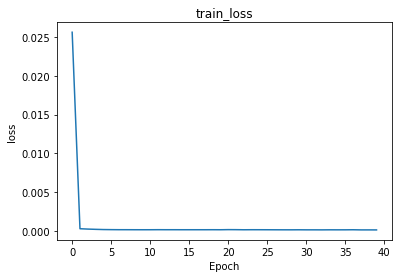

In [121]:
import matplotlib.pyplot as plt
%matplotlib inline

# loss graph
plt.title('train_loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.plot( history.history["loss"])

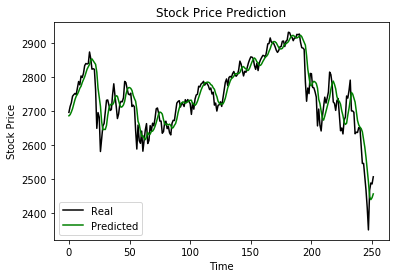

In [131]:
dataset_total = pd.concat((train['Close Price'], test['Close Price']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test) - 5:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

test_x = []
for i in range(5, len(inputs)):
    test_x.append(inputs[i-5: i, 0])
test_x = np.array(test_x)
test_x = np.reshape(test_x, (test_x.shape[0], test_x.shape[1], 1))
predicted_stock_price = regressor.predict(test_x)
#使用sc的 inverse_transform將股價轉為歸一化前
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

plt.plot(test['Close Price'].values, color = 'black', label = 'Real')
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [132]:
len(predicted_stock_price), len(test["Close Price"])

(252, 252)

In [136]:
#建立label
def label_convert(train):
    data = []
    for i in range(len(train) - 5):
        if (i == 0):
            data.append(0)
            continue
        if train[i + 5] > train[i] :
            data.append(1)
        else:
            data.append(0)
    return data

ans1 = label_convert(predicted_stock_price)
ans2 = label_convert(test["Close Price"])

print("accuracy :", end=" ")
print(str(round(metrics.accuracy_score(ans1, ans2) * 100, 2)) + " %" )

accuracy : 69.23 %


## Random Forest Classifier

In [139]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

train["label"] = add_label(train, "Close Price")
test["label"] = add_label(test, "Close Price")

In [142]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation, ensemble, preprocessing, metrics

nor_list = ["Open Price", "Close Price", "High Price", "Low Price", "Volume"]

train_x, train_y = train[nor_list], train["label"]
test_x, test_y = test[nor_list], test["label"]

model = RandomForestClassifier(n_estimators = 10)
model.fit(train_x, train_y)

pred_y = model.predict(test_x)
print("accuracy :", end=" ")
print(str(round(metrics.accuracy_score(pred_y, test_y) * 100, 2)) + " %" )

accuracy : 47.22 %


In [143]:
from sklearn.svm import SVC

svm = SVC()
svm.fit(train_x, train_y)
pred_y = svm.predict(test_x)

print("accuracy :", end=" ")
print(str(round(metrics.accuracy_score(pred_y, test_y) * 100, 2)) + " %" )

accuracy : 52.38 %
